In [33]:
import os
import random
import librosa
import librosa.feature as F
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio
import os.path as path
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio


In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [21]:
zip_path = "hse-itmo-acoustic-event-detection-2025.zip"

base_folder = "hse-itmo-acoustic-event-detection-2025"

if not path.exists(base_folder):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(base_folder)
train_dir = path.join(base_folder, "train")

if not path.exists(train_dir):
    audio_train_root = path.join(base_folder, "audio_train")
    nested_train = path.join(audio_train_root, "train")

    if path.isdir(nested_train):
        os.rename(nested_train, train_dir)
        try:
            if not os.listdir(audio_train_root):
                os.rmdir(audio_train_root)
        except FileNotFoundError:
            pass
    elif path.isdir(audio_train_root):
        wavs_inside = glob.glob(path.join(audio_train_root, "*.wav"))
        if wavs_inside:
            os.rename(audio_train_root, train_dir)

print("base_folder:", base_folder)
print("Содержимое base_folder:", os.listdir(base_folder))
print("Содержимое train:", os.listdir(train_dir)[:10]) 


base_folder: hse-itmo-acoustic-event-detection-2025
Содержимое base_folder: ['audio_test', 'train', 'train.csv', 'sample_submission.csv']
Содержимое train: ['72371c1946c15ff68055.wav', '58ecb67474d3b7f88050.wav', '4a1a60c6676cad48ba7c.wav', '5ecc5ba70d1ec5fad18b.wav', 'e7a8f5f72cdc3ffa2175.wav', 'f4c498a2e9e12ea597bc.wav', '25e574aae6ab78b486cf.wav', '56009966c19d91eed5cf.wav', '59375b4f9de6ccb11e12.wav', '606ed8f55f4954c465f3.wav']


In [23]:
train_folder = path.join(base_folder, "train")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join(base_folder, "train.pickle")
labels_pickle = path.join(base_folder, "labels.pickle")


In [142]:
labels_df = pd.read_csv(train_csv)
n_classes = labels_df["label"].nunique()
print("n_classes:", n_classes)


n_classes: 41


In [25]:
files = os.listdir(train_folder)
filename = random.choice(files)
filename

'10ddd7cd6b4054e73b97.wav'

In [237]:
from collections import Counter


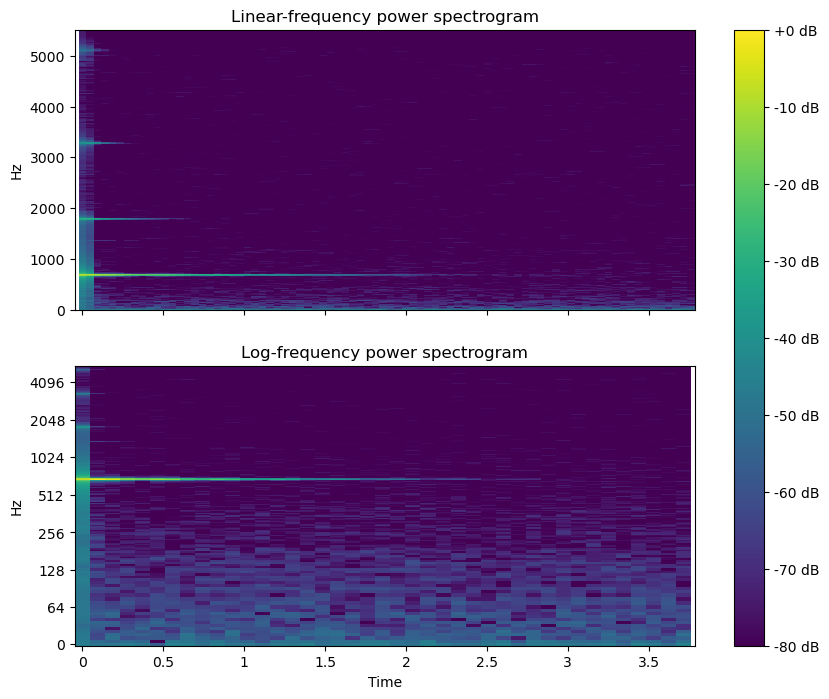

In [35]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

# draw linear-frequency spectrogram
hop_length = 512
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img1 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_top,
    x_axis='time',
    y_axis='linear',
    cmap=cmap,
)
ax_top.set(title='Linear-frequency power spectrogram')
ax_top.label_outer()

# draw log-frequency spectrogram
hop_length = 1024
wav_data_db = librosa.amplitude_to_db(
    np.abs(librosa.stft(wav_data, hop_length=hop_length)),
    ref=np.max
)
img2 = librosa.display.specshow(
    wav_data_db,
    sr=sr,
    hop_length=hop_length,
    ax=ax_bottom,
    x_axis='time',
    y_axis='log',
    cmap=cmap,
)
ax_bottom.set(title='Log-frequency power spectrogram')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

In [ ]:
Mel-спектрограмма

In [37]:
# melspectrogram parameters
sample_rate = 11025
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

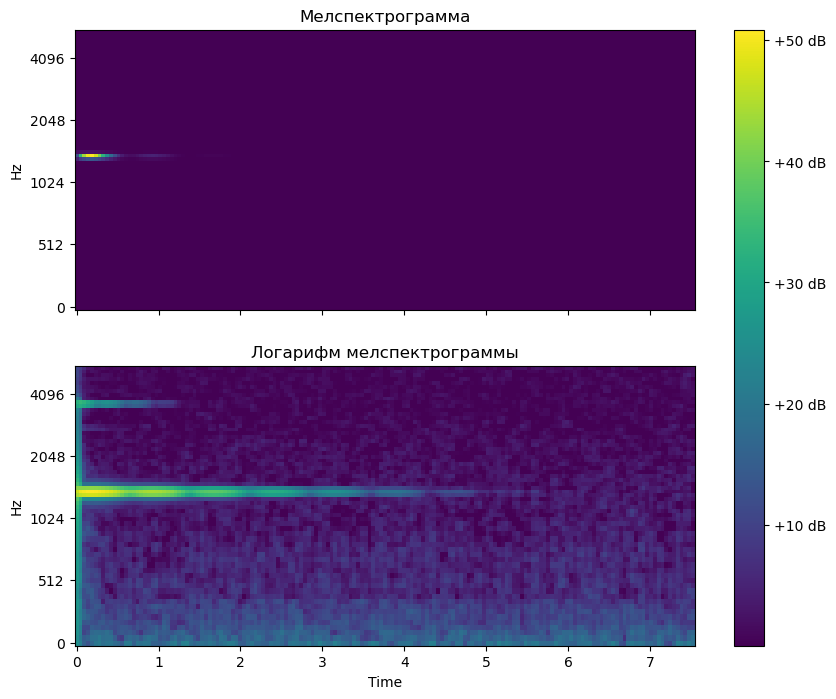

In [39]:
wav_data, sr = librosa.load(os.path.join(train_folder, filename), sr=sample_rate)

mel_spec = F.melspectrogram(
    y=wav_data,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels, 
    fmax=sample_rate // 2
)

fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
cmap = "viridis"

img1 = librosa.display.specshow(
    mel_spec,
    sr=sr,
    fmax=sr // 2,
    ax=ax_top,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_top.set(title='Мелспектрограмма')
ax_top.label_outer()

D = librosa.power_to_db(mel_spec, ref=np.max)
img2 = librosa.display.specshow(
    D,
    sr=sr,
    fmax=sr // 2,
    ax=ax_bottom,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax_bottom.set(title='Логарифм мелспектрограммы')
ax_bottom.label_outer()

fig.colorbar(img1, ax=[ax_top, ax_bottom], format="%+2.f dB")
plt.show()

display(Audio(wav_data, rate=sr))

In [ ]:
Извлечение признаков

In [41]:
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional

from tqdm import tqdm

import pandas as pd
import numpy as np

import librosa
import librosa.feature as F


class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3

class AudioAugmentation:
    
    @staticmethod
    def add_noise(audio, noise_factor=0.005):
        noise = np.random.randn(len(audio)) * noise_factor
        return audio + noise
    
    @staticmethod
    def shift_time(audio, shift_max=0.2):
        shift = np.random.randint(-int(len(audio) * shift_max), int(len(audio) * shift_max))
        if shift > 0:
            return np.pad(audio[shift:], (0, shift), mode='constant')
        else:
            return np.pad(audio[:shift], (-shift, 0), mode='constant')
    
    @staticmethod
    def change_pitch(audio, sr, pitch_factor=0.2):
        return librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_factor)
    
    @staticmethod
    def change_speed(audio, speed_factor=0.2):
        return librosa.effects.time_stretch(audio, rate=1 + speed_factor)
        
def extract_log_mel_feats(audio, sr=22050, n_mels=128, n_fft=2048, hop_length=512, augment=False, target_length=256):
    if sr != 22050:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=22050)
        sr = 22050
    
    # Аугментация данных
    if augment and np.random.random() > 0.5:
        aug = AudioAugmentation()
        augmentations = [
            lambda: aug.add_noise(audio),
            lambda: aug.shift_time(audio),
            lambda: aug.change_pitch(audio, sr),
            lambda: aug.change_speed(audio)
        ]
        augmentation_func = np.random.choice(augmentations)
        audio = augmentation_func()

        # Фиксируем длину аудио
    if len(audio) < sr * 2:  # Если аудио короче 2 секунд
        audio = np.pad(audio, (0, max(0, sr * 2 - len(audio))), mode='constant')
    else:  # Если длиннее 2 секунд, обрезаем до 2 секунд
        audio = audio[:sr * 2]
    
    # Извлекаем Mel-спектрограмму с большим количеством фильтров
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmin=20,
        fmax=sr//2
    )
    
    # Логарифмируем и нормализуем
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Стандартизация
    mean = np.mean(log_mel)
    std = np.std(log_mel)
    log_mel = (log_mel - mean) / (std + 1e-8)
    
    # Добавляем дельта-фичи (производные) для временных изменений
    delta = librosa.feature.delta(log_mel)
    delta2 = librosa.feature.delta(log_mel, order=2)
    
    # Объединяем основные фичи + дельты
    features = np.stack([log_mel, delta, delta2], axis=0)
    
    return features

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, file_list, labels, label_to_idx, train=True):
        self.file_list = file_list
        self.labels = labels
        self.train = train
        self.label_to_idx = label_to_idx
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        audio_path = self.file_list[idx]
        label = self.labels[idx]
        
        # Load audio
        audio, sr = librosa.load(audio_path, sr=22050)
        
        # Extract features with augmentation for training
        features = extract_log_mel_feats(audio, sr=sr, augment=self.train)
        
        # Convert to tensor
        features = torch.FloatTensor(features)
        label_idx = self.label_to_idx[label]
        
        return features, label_idx

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3, dropout_rate=0.3):
        super(ImprovedCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Первый блок сверток
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate),
            
            # Второй блок сверток
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate),
            
            # Третий блок сверток
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_rate),
            
            # Четвертый блок сверток
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Dropout2d(dropout_rate)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [268]:
train_data = pickle.load(open(train_pickle, "rb"))

label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

In [270]:
def prepare_shape(feature, N=256, train=True):
    """
    feature: np.ndarray формы (n_mels, T)
    N: длина по времени после кропа
    train: если True — случайный сдвиг, если False — центрированный кроп
    """
    tmp = feature.astype(np.float32)

    mean = tmp.mean()
    std = tmp.std()
    if std < 1e-6:
        std = 1e-6
    tmp = (tmp - mean) / std

    if tmp.shape[1] < N:
        pad = N - tmp.shape[1]
        tmp = np.pad(tmp, ((0, 0), (0, pad)), mode="constant")

    max_start = tmp.shape[1] - N
    if max_start < 0:
        start = 0
    else:
        if train:
            start = np.random.randint(0, max_start + 1)
        else:
            start = max_start // 2

    tmp = tmp[:, start:start + N]     
    tmp = tmp[np.newaxis, :, :]       

    return tmp


In [272]:
from sklearn.model_selection import StratifiedShuffleSplit

validation_set_size = 800 

x_all = []
y_all = []

for row in train_data:
    x_all.append(row['feature'])    # (64, T)
    y_all.append(row['label_id'])

y_all = np.asarray(y_all)

print("Всего объектов в train:", len(x_all))
print("Число классов:", len(np.unique(y_all)))

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=validation_set_size,
    random_state=random_state,
)

for train_idx, val_idx in sss.split(np.zeros_like(y_all), y_all):
    x_tr = [x_all[i] for i in train_idx]
    y_tr = y_all[train_idx]

    x_val = [x_all[i] for i in val_idx]
    y_val = y_all[val_idx]

print("Train size:", len(x_tr))
print("Val size:  ", len(x_val))
print("Пример формы признаков:", x_tr[0].shape)


Всего объектов в train: 5683
Число классов: 41
Train size: 4883
Val size:   800
Пример формы признаков: (64, 73)


In [186]:

from torch.utils.data import Dataset

In [274]:
from torch.utils.data import Dataset

class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu", train=True):
        """
        x: список np.ndarray формы (n_mels, T) разной длины
        y: массив меток или None
        """
        self.x = x
        self.y = y
        self.device = device
        self.train = train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        feature = self.x[idx]                        
        feature = np.asarray(feature, dtype=np.float32)
        feature = prepare_shape(feature, N=256, train=self.train)

        x_tensor = torch.tensor(feature, dtype=torch.float32, device=self.device)

        if self.y is not None:
            y_tensor = torch.tensor(self.y[idx], dtype=torch.long, device=self.device)
            return x_tensor, y_tensor

        return x_tensor


In [276]:

set_random_state(random_state)

sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(26, 'Laughter')

In [89]:
import librosa
import matplotlib.pyplot as plt

In [164]:
sample_rate = 11025

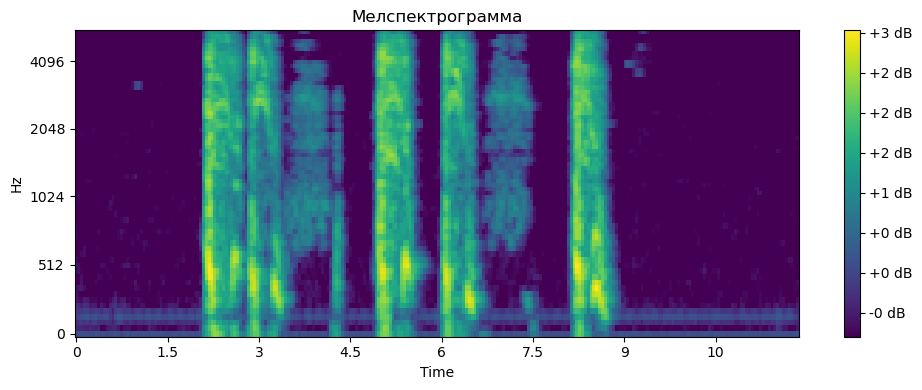

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
cmap = "viridis"

img = librosa.display.specshow(
    sample_x[0].numpy(force=True),
    sr=sample_rate,
    fmax=sample_rate // 2,
    ax=ax,
    x_axis='time',
    y_axis='mel',
    cmap=cmap,
)
ax.set(title='Мелспектрограмма')
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.tight_layout()
plt.show()

In [278]:
from torch.utils.data import DataLoader

num_workers = 0

train_dset = EventDetectionDataset(x_tr, y_tr, device=device, train=True)
val_dset   = EventDetectionDataset(x_val, y_val, device=device, train=False)

train_loader = DataLoader(train_dset, batch_size=64, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dset,   batch_size=64, shuffle=False, num_workers=num_workers)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [283]:

file_list = [path.join(train_folder, fname) for fname in labels_df['fname']]
labels_list = labels_df['label'].values

train_files, val_files, train_labels, val_labels = train_test_split(
    file_list, labels_list, test_size=0.2, random_state=42, stratify=labels_list
)

target_length = 256
train_dataset = AudioDataset(train_files, train_labels, label_to_idx, train=True)
val_dataset = AudioDataset(val_files, val_labels, label_to_idx, train=False)

train_loader = DataLoader(
    train_dataset, 
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [319]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = ImprovedCNN(num_classes=n_classes, input_channels=3, dropout_rate=0.3)
model = model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.001,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
early_stopping = EarlyStopping(patience=15, min_delta=0.001)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
best_val_f1 = 0.0
train_losses = []
val_losses = []
val_f1_scores = []

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = 100.0 * train_correct / train_total
    
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved with F1: {val_f1:.4f}")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
    print(f'  Best Val F1: {best_val_f1:.4f}')
    print('-' * 50)

print(f"Training completed. Best validation F1: {best_val_f1:.4f}")


Using device: cpu
Starting training...
New best model saved with F1: 0.2480
Epoch 1/100:
  Train Loss: 3.1360, Train Acc: 18.68%
  Val Loss: 2.7010, Val F1: 0.2480
  Best Val F1: 0.2480
--------------------------------------------------
New best model saved with F1: 0.3404
Epoch 2/100:
  Train Loss: 2.7430, Train Acc: 28.33%
  Val Loss: 2.5102, Val F1: 0.3404
  Best Val F1: 0.3404
--------------------------------------------------
New best model saved with F1: 0.3758
Epoch 3/100:
  Train Loss: 2.6021, Train Acc: 33.96%
  Val Loss: 2.3853, Val F1: 0.3758
  Best Val F1: 0.3758
--------------------------------------------------
New best model saved with F1: 0.4286
Epoch 4/100:
  Train Loss: 2.4962, Train Acc: 38.41%
  Val Loss: 2.2319, Val F1: 0.4286
  Best Val F1: 0.4286
--------------------------------------------------
New best model saved with F1: 0.4665
Epoch 5/100:
  Train Loss: 2.3917, Train Acc: 41.14%
  Val Loss: 2.1760, Val F1: 0.4665
  Best Val F1: 0.4665
----------------------

KeyboardInterrupt: 

/var/folders/0p/03gxzkxs08qbngvzqctwvr6h0000gn/T/ipykernel_12279/1626501312.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Final Validation F1 Score: 0.7045


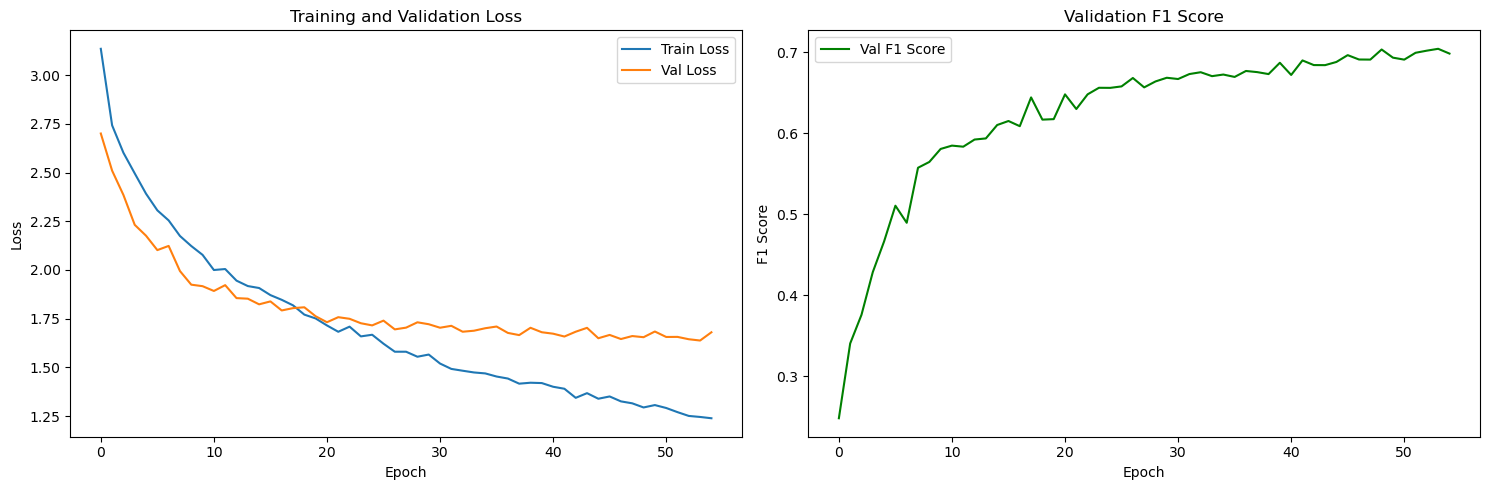

In [321]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

final_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Final Validation F1 Score: {final_f1:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Val F1 Score', color='green')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [325]:
# Prepare submission
test_folder = path.join(base_folder, "audio_test", "test")
sample_submission = pd.read_csv(path.join(base_folder, "sample_submission.csv"))

print("Generating predictions for test set...")
test_predictions = []

model.eval()
with torch.no_grad():
    for fname in sample_submission['fname']:
        audio_path = path.join(test_folder, fname)
        try:
            audio, sr = librosa.load(audio_path, sr=22050)
            features = extract_log_mel_feats(audio, sr=sr, augment=False, target_length=256)
            features = torch.FloatTensor(features).unsqueeze(0).to(device)
            
            output = model(features)
            _, predicted = torch.max(output.data, 1)
            
            # Convert back to label
            predicted_label = idx_to_label[predicted.item()]
            test_predictions.append(predicted_label)
        except Exception as e:
            print(f"Error processing {fname}: {e}")
            # Fallback prediction
            test_predictions.append(unique_labels[0])

# Create submission file
submission_df = sample_submission.copy()
submission_df['label'] = test_predictions
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created!")
print(f"Predicted class distribution:\n{submission_df['label'].value_counts()}")

Generating predictions for test set...
Submission file 'submission.csv' created!
Predicted class distribution:
label
Writing                  218
Tearing                  155
Oboe                     144
Clarinet                 136
Snare_drum               135
Saxophone                131
Gong                     128
Applause                 128
Laughter                 128
Bass_drum                123
Double_bass              120
Fireworks                115
Hi-hat                   112
Acoustic_guitar          110
Flute                    110
Violin_or_fiddle         109
Fart                     108
Cello                    108
Cough                    105
Trumpet                  103
Knock                    103
Burping_or_eructation    102
Shatter                   92
Bark                      86
Harmonica                 82
Squeak                    79
Tambourine                78
Bus                       66
Cowbell                   66
Electric_piano            56
Microwave_ove